# Corrective RAG (CRAG)

이 튜토리얼은 Corrective-RAG (CRAG) 전략을 구현하는 방법을 설명합니다. CRAG는 검색된 문서에 대한 자기 반성 및 자기 평가를 포함하는 RAG 전략입니다. 이 튜토리얼에서는 LangGraph를 사용하여 이러한 아이디어를 처음부터 구현하는 방법을 다룹니다.

이 튜토리얼의 목적은 CRAG의 주요 개념을 이해하고, 이를 LangGraph를 통해 구현하여 검색 및 생성 작업을 최적화하는 것입니다. 이를 통해 사용자는 검색된 문서의 관련성을 평가하고, 필요에 따라 웹 검색을 통해 추가 데이터를 보충하는 방법을 배울 수 있습니다.

**Corrective-RAG (CRAG)** 는 검색된 문서에 대한 자기 반성 및 자기 평가를 포함하는 **RAG** 전략입니다.

논문 [여기](https://arxiv.org/pdf/2401.15884.pdf)에서 다음과 같은 단계가 수행됩니다.

- 적어도 하나의 문서가 관련성 임계값을 초과하면 생성 단계로 진행합니다.
- 생성 전에 지식 정제를 수행합니다.
- 문서를 "knowledge strips"로 분할합니다.
- 각 스트립을 평가하고 관련 없는 것을 필터링합니다.
- 모든 문서가 관련성 임계값 이하이거나 평가자가 확신이 없으면 추가 데이터 소스를 찾습니다.
- 웹 검색을 사용하여 검색을 보완합니다.

이러한 아이디어 중 일부를 [LangGraph](https://langchain-ai.github.io/langgraph/)를 사용하여 처음부터 구현합니다.

- 첫 번째 단계로 지식 정제 단계를 생략합니다. 필요에 따라 노드로 추가할 수 있습니다.
- **어떤** 문서라도 관련이 없으면 웹 검색으로 검색을 보완합니다.
- 웹 검색을 위해 [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/)를 사용합니다.
- 웹 검색을 최적화하기 위해 쿼리 재작성을 사용합니다.

**주로 다루는 내용**
- Corrective RAG (CRAG) 소개: CRAG의 개념과 주요 단계 설명
- Setup: 필요한 패키지 설치 및 API 키 설정
- Create Index: 블로그 게시물 색인 생성
- LLMs: 대형 언어 모델(LLM) 사용
- Retrieval Grader: 검색된 문서의 관련성 평가
- Generate: 답변 생성
- Question Re-writer: 질문 재작성
- Web Search Tool: 웹 검색 도구 사용
- Create Graph: CRAG를 사용할 그래프 생성
- Use the graph: 그래프 사용 방법

## 환경 설정

In [4]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [5]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

In [6]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## LLMs

**대형 언어 모델(LLMs)** 는 자연어 처리 작업에서 중요한 역할을 합니다. LLMs는 대량의 텍스트 데이터를 학습하여 다양한 언어 이해 및 생성 작업을 수행할 수 있습니다. 이 튜토리얼에서는 `OpenAI`의 `GPT` 모델을 사용하여 검색된 문서의 내용을 기반으로 답변을 생성합니다.

- **LLM의 역할**: 검색된 문서에서 관련 정보를 추출하고, 이를 바탕으로 자연스러운 언어로 답변을 생성합니다.
- **모델 선택**: `OpenAI`의 `GPT` 모델을 사용하여 높은 품질의 텍스트 생성을 보장합니다.
- **응용 분야**: LLMs는 챗봇, 번역, 요약, 질의응답 시스템 등 다양한 분야에 활용될 수 있습니다.

LLMs의 활용을 통해 검색 및 생성 작업의 효율성을 극대화할 수 있습니다.

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs
from pydantic import BaseModel, Field

# 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 구조화된 출력을 생성하는 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 결과 평가(Evaluator) 생성
retrieval_grader = grade_prompt | structured_llm_grader

In [8]:
# 질문 정의
question = "Anthropic 에 투자한 기업의 정보를 알려주세요"

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색 결과 평가
print(retrieval_grader.invoke({"question": question, "document": docs}))

binary_score='yes'


In [9]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# LangChain Hub에서 RAG 프롬프트를 가져와 사용
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수 정의
# 검색된 문서의 페이지 내용을 결합하여 하나의 문자열로 반환
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# 체인 생성
# 프롬프트, LLM, 문자열 출력 파서를 연결하여 체인 생성
rag_chain = prompt | llm | StrOutputParser()

# 체인 실행 및 결과 출력
# 주어진 문맥과 질문을 사용하여 체인을 실행하고 생성된 답변 출력
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 5억 달러를 우선 투자했습니다. 이 외에도 구글은 AI 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어 기업 허깅 페이스(Hugging Face)에도 투자하고 있습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


### Question Re-writer

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# 대형 언어 모델(LLM) 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 웹 검색에 최적화된 질문으로 변환하는 질문 재작성기 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Question Re-writer 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

원본 질문과 재작성된 쿼리를 비교합니다.

In [11]:
# 원본 질문 출력
print(f"[원본 질문] {question}")

# 실행 및 결과 확인
print(f'[재작성된 결과] {question_rewriter.invoke({"question": question})}')

[원본 질문] Anthropic 에 투자한 기업의 정보를 알려주세요
[재작성된 결과] "Anthropic에 투자한 기업 목록과 그들의 투자 규모는 무엇인가요?"


## 웹 검색 도구

**웹 검색 도구**는 검색된 문서의 관련성을 보완하기 위해 사용됩니다. 이 도구는 추가적인 정보를 제공하여 검색 및 생성 작업의 정확성을 높입니다.

- **웹 검색의 필요성**: 모든 문서가 관련성 임계값을 충족하지 않거나 평가자가 확신이 없을 때, 웹 검색을 통해 추가 데이터를 확보합니다.
- **Tavily Search 사용**: Tavily Search를 활용하여 웹 검색을 수행합니다. 이는 검색 쿼리를 최적화하고, 보다 관련성 높은 결과를 제공합니다.
- **질문 재작성**: 웹 검색을 최적화하기 위해 질문을 재작성하여 검색 쿼리를 개선합니다.

이러한 과정을 통해 검색된 문서의 품질을 높이고, 보다 정확한 답변 생성을 지원합니다.

In [12]:
from langchain_teddynote.tools.tavily import TavilySearch
import ast

# TavilySearch 도구 생성
web_search_tool = TavilySearch(max_results=3, format_output=True)

# 웹 검색 결과 출력
results = web_search_tool.invoke({"query": question})
results = ast.literal_eval(results)
print(results)

['<document><title>\'오픈AI 라이벌\' 앤스로픽, 1兆 투자 성공…AI 쩐의 전쟁 불 붙었다 - ZDNet korea</title><url>https://zdnet.co.kr/view/?no=20240221075847</url><content>오픈AI, 구글과 함께 세계 3대 LLM(거대언어모델)을 보유한 기업으로 알려진 인공지능(AI) 스타트업 앤스로픽(Anthropic)이 또 다시 대규모 투자 유치에</content><raw>\'오픈AI 라이벌\' 앤스로픽, 1兆 투자 성공…AI 쩐의 전쟁 불 붙었다\n구글·아마존 이어 멘로 벤처스서 7억5천만 달러 투자금 유치…오픈AI도 투자 유치 활발\n컴퓨팅입력 :2024/02/21 10:07\n오픈AI, 구글과 함께 세계 3대 LLM(거대언어모델)을 보유한 기업으로 알려진 인공지능(AI) 스타트업 앤스로픽(Anthropic)이 또 다시 대규모 투자 유치에 성공했다.\n21일 뉴욕타임스에 따르면 앤스로픽은 이달 중 미국 벤처 캐피털 멘로 벤처스로부터 7억5천만 달러(약 9천700억원) 투자금을 유치했다.\xa0앤스로픽이 지난 1년간 끌어온 투자금은 총 73억 달러에 달한다.\n구글과 끈끈한 파트너십을 유지하고 있는 앤스로픽은 지난 2021년 오픈AI에 있던 직원이 공동 설립했다. 구글, 세일즈포스 등을 통해 4억5천만 달러를 유치한 후 전 세계 곳곳에서 투자금이 쏟아지고 있는데, 국내 기업 중에선 LG가 LG테크놀로지벤처스를 통해 지분 투자에 나서 주목 받았다. 첫 투자금은 폴라리스벤처스로부터 1억2천400만 달러를 유치했다.\n지난해 8월에는 아시아 통신사 두 곳으로부터 1억 달러를 유치했고, 아마존과 구글은 40억 달러, 20억 달러를 더 투자했다. 앤스로픽은 투자한 회사들의 칩, 클라우드 컴퓨팅 서비스 등을 사용하며 사실상 모금한 자금의 일부를 투자자들에게 다시 돌려주고 있다. 챗GPT의 강력한 대항마로 떠오른 인공지능(AI) 챗봇 \'클로드(Claude)\'의 경우 아마존의 클라우드 컴퓨팅 시

## 그래프 생성

이제 **CRAG**를 사용할 그래프를 생성합니다.

### 그래프 상태 정의

- **그래프 상태**는 **CRAG**의 구현에 필수적인 요소입니다.
- **CRAG**의 각 단계에서 필요한 데이터를 저장하고 관리합니다.
- **LangGraph**를 사용하여 그래프 상태를 정의하고, 각 노드와 엣지의 관계를 설정합니다.
- **CRAG**의 효율적인 작동을 위해 상태를 최적화합니다.

이 과정을 통해 **CRAG**의 기능을 최대한 활용할 수 있는 그래프를 구축할 수 있습니다.

In [13]:
from typing import List

from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 데이터 구조 정의
class GraphState(TypedDict):
    """
    그래프 상태 정의
    """

    question: Annotated[str, "question"]
    generation: Annotated[str, "answer"]
    web_search: Annotated[str, "web search"]
    documents: Annotated[List[str], "documents"]

In [14]:
from langchain.schema import Document


# 문서 검색
def retrieve(state):
    # 질문
    question = state["question"]
    # 검색
    documents = pdf_retriever.invoke(question)
    return {"documents": documents, "question": question}


# 답변 생성
def generate(state):
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


# 문서 평가
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # 문서 평가
    filtered_docs = []
    web_search = "No"
    docs_str = "\n".join(
        [
            f"<content>{doc.page_content}</content><metadata><source>{doc.metadata['source']}</source><page>{doc.metadata['page']}</page></metadata>"
            for doc in documents
        ]
    )
    score = retrieval_grader.invoke({"question": question, "document": docs_str})

    if score.binary_score == "yes":
        filtered_docs = documents
        web_search = "No"
    else:
        filtered_docs = []
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


# 질문 재작성
def transform_query(state):
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


# 웹 검색
def web_search(state):
    question = state["question"]
    documents = state["documents"]

    # 웹 검색
    results = web_search_tool.invoke({"query": question})
    documents.append(results)

    return {"documents": documents, "question": question}

### Edges

In [15]:
def decide_to_generate(state):
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### 그래프 컴파일

위 그림에서 설명한 흐름을 따릅니다.

In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
# 문서 검색
workflow.add_node("retrieve", retrieve)
# 문서 평가
workflow.add_node("grade_documents", grade_documents)
# 답변 생성
workflow.add_node("generate", generate)
# 질문 재작성
workflow.add_node("transform_query", transform_query)
# 웹 검색
workflow.add_node("web_search_node", web_search)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

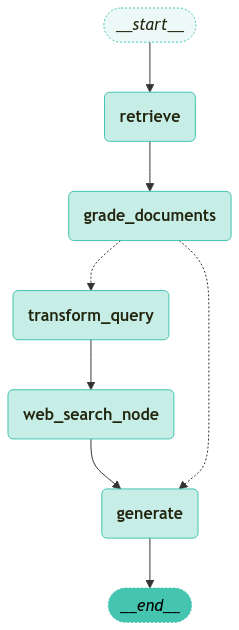

In [17]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 사용

- **그래프 실행**: `app` 객체를 사용하여 그래프를 실행합니다. 그래프의 시작 상태를 정의하고, 각 노드의 기능을 순차적으로 수행합니다.
- **질문 입력**: 사용자가 입력한 질문을 그래프의 초기 상태로 설정합니다.
- **문서 검색**: `retrieve` 노드를 통해 질문에 대한 관련 문서를 검색합니다.
- **문서 평가**: `grade_documents` 노드를 사용하여 검색된 문서의 관련성을 평가합니다.
- **질문 변환**: 필요에 따라 `transform_query` 노드를 통해 질문을 재작성하여 웹 검색을 최적화합니다.
- **웹 검색**: `web_search_node`를 통해 추가적인 웹 검색을 수행하여 관련 데이터를 보충합니다.
- **답변 생성**: `generate` 노드를 통해 최종 답변을 생성합니다.
- **결과 출력**: 생성된 답변을 사용자에게 제공합니다.

이 과정을 통해 **CRAG**의 기능을 최대한 활용하여 검색 및 생성 작업의 효율성을 높일 수 있습니다.

In [21]:
import uuid
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


def ask(question):
    inputs = {"question": question}
    stream_graph(
        app,
        inputs,
        config=config,
        node_names=[
            "transform_query",
            "generate",
            "retrieve",
            "grade_documents",
            "web_search_node",
        ],
    )

In [22]:
# 질문 입력
ask("Anthropic 에 투자한 기업의 정보를 알려주세요")

---CHECK DOCUMENT RELEVANCE TO QUESTION---

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
---DECISION: GENERATE---

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 5억 달러를 우선 투자했습니다. 이 외에도 구글은 AI 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어 기업 허깅 페이스(Hugging Face)에도 투자하고 있습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)

In [23]:
ask("SK AI Summit 2024 파트너사 명단을 알려주세요")

---CHECK DOCUMENT RELEVANCE TO QUESTION---

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---

🔄 Node: transform_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
"2024 SK AI Summit의 파트너사 목록은 무엇인가요?"
🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024 SK AI Summit의 파트너사 목록은 다음과 같습니다: Microsoft, NVIDIA, TSMC, OpenAI, SK Telecom, SK hynix, Lambda, Penguin Solutions, TerraPower, Perplexity, Kakao 등입니다.

**Source**
- https://eng.sk.com/news/sk-group-hosts-sk-ai-summit-2024-to-drive-global-ai-exchange-and-innovation